In [1]:
# If needed, install interactive backend & widgets (uncomment as needed):
# %pip install -q ipympl ipywidgets

# Enable interactive Matplotlib for clicks & live updates:
%matplotlib widget


In [2]:
import io, math, urllib.request
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from transformers import AutoModel

try:
    import ipywidgets as Widget
except Exception:
    Widget = None  # slider is optional

# ---------- Image I/O ----------
def load_image(url_str):
    """Download an image from URL and return a PIL RGB image."""
    with urllib.request.urlopen(url_str) as resp:
        data = resp.read()
    return Image.open(io.BytesIO(data)).convert("RGB")

# ---------- Preprocessing (custom, NO resize) ----------
def pad_to_multiple(pil_img, multiple=16):
    """Pad PIL image on right/bottom so (H,W) are multiples of `multiple`."""
    W, H = pil_img.size
    H_pad = int(math.ceil(H / multiple) * multiple)
    W_pad = int(math.ceil(W / multiple) * multiple)
    if (H_pad, W_pad) == (H, W):
        return pil_img, (0, 0, 0, 0)
    canvas = Image.new("RGB", (W_pad, H_pad), (0, 0, 0))
    canvas.paste(pil_img, (0, 0))
    return canvas, (0, 0, W_pad - W, H_pad - H)

def preprocess_image_no_resize(pil_img):
    """Pad (right/bottom) -> ToTensor -> Normalize (ImageNet stats)."""
    img_padded, pad_box = pad_to_multiple(pil_img, multiple=16)
    transform = transforms.Compose([
        transforms.ToTensor(),  # [0,1], CxHxW
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    pixel_tensor = transform(img_padded).unsqueeze(0)  # (1,3,H,W)
    disp_np = np.array(img_padded, dtype=np.uint8)     # (H,W,3) for display
    return {"pixel_values": pixel_tensor}, disp_np, pad_box

# ---------- Small drawing utilities ----------
def upsample_nearest(arr, H, W, ps):
    """Nearest upsample for 2D or 3D arrays with last-dim channels."""
    if arr.ndim == 2:
        return arr.repeat(ps, 0).repeat(ps, 1)
    elif arr.ndim == 3:
        C = arr.shape[-1]
        return arr.repeat(ps, 0).repeat(ps, 1).reshape(H, W, C)
    raise ValueError("Unsupported ndim for upsample")

def draw_grid(ax, rows, cols, ps):
    for r in range(1, rows):
        ax.axhline(r * ps - 0.5, lw=0.8, alpha=0.6, color="white", zorder=3)
    for c in range(1, cols):
        ax.axvline(c * ps - 0.5, lw=0.8, alpha=0.6, color="white", zorder=3)

def draw_indices(ax, rows, cols, ps):
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            ax.text(c * ps + ps / 2, r * ps + ps / 2, str(idx),
                    ha="center", va="center", fontsize=7,
                    color="white", alpha=0.95, zorder=4)


[info] Device: cpu; Original image size (WxH): (640, 480)


[info] Controls: click to select • arrow keys to move (ipympl) • slider optional


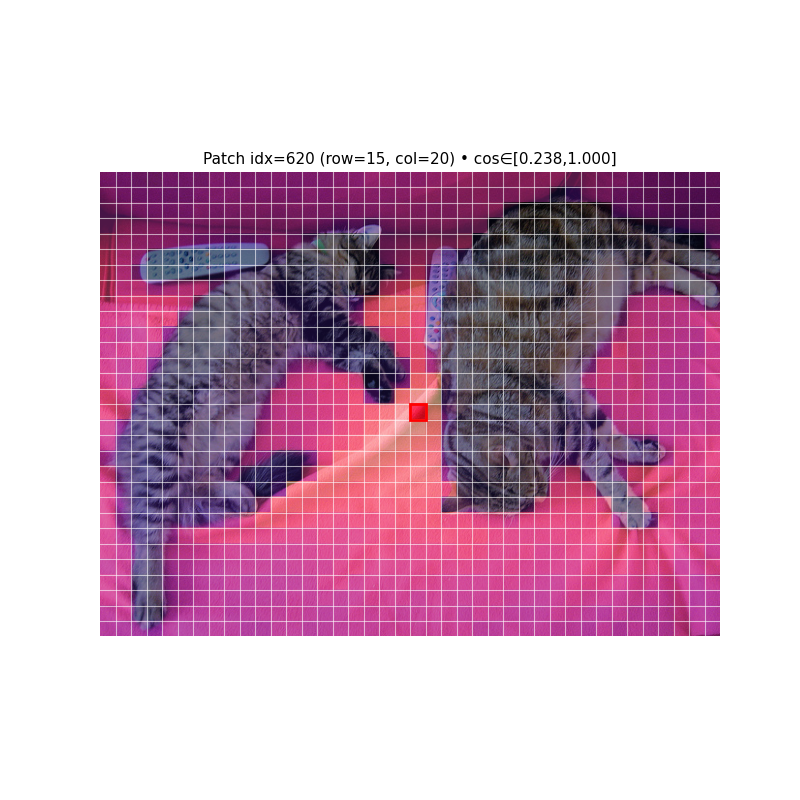

In [3]:
# ---- Available DINOv3 models on Hugging Face ----
# model_id = "facebook/dinov3-vit7b16-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vits16-pretrain-lvd1689m"
# model_id = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vitb16-pretrain-lvd1689m"
# model_id = "facebook/dinov3-convnext-base-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
# model_id = "facebook/dinov3-convnext-tiny-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vitl16-pretrain-sat493m"
# model_id = "facebook/dinov3-vitl16-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vith16plus-pretrain-lvd1689m"
# model_id = "facebook/dinov3-convnext-large-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vit7b16-pretrain-sat493m"

# ---- User config ----
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
model_id = "facebook/dinov3-vits16-pretrain-lvd1689m"  # Choose one from above
show_grid = True
annotate_indices = False
overlay_alpha = 0.55
patch_size_override = None  # set to 16 to force; None = read from model if available
# ----------------------

# Load URL image
image = load_image(url)

# Device & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[info] Device: {device}; Original image size (WxH): {image.size}")

model = AutoModel.from_pretrained(model_id).to(device)
model.eval()

# Preprocess (NO resize, right/bottom pad only)
inputs, img_disp, _ = preprocess_image_no_resize(image)
pixel_values = inputs["pixel_values"].to(device)  # (1,3,H,W)
_, _, H, W = pixel_values.shape

# Patch size & grid
ps = patch_size_override
if ps is None:
    ps = getattr(getattr(model, "config", object()), "patch_size", 16)
rows, cols = H // ps, W // ps

# Forward pass (get token features)
with torch.no_grad():
    out = model(pixel_values=pixel_values)
hs = out.last_hidden_state.squeeze(0).detach().cpu().numpy()  # (T, D)
T, D = hs.shape
n_patches = rows * cols

# Robustly take the LAST n_patches tokens as patch tokens (works with/without registers)
patch_embs = hs[-n_patches:, :].reshape(rows, cols, D)

# Precompute normalized patch matrix for fast cosine
X = patch_embs.reshape(-1, D)                      # (N, D)
X_norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-8
Xn = X / X_norms                                   # (N, D)

# Figure
fig, ax = plt.subplots(figsize=(8, 8))
base_im = ax.imshow(img_disp, zorder=0)
ax.set_axis_off()

# Heatmap overlay as RGBA via colormap
cmap = plt.get_cmap("magma")
init_scalar = 0.5 * np.ones((rows, cols), dtype=np.float32)
rgba_init = cmap(init_scalar)                      # (rows, cols, 4) in [0,1]
overlay = ax.imshow(upsample_nearest(rgba_init, H, W, ps), alpha=overlay_alpha, zorder=1)

# Grid / indices above overlay
if show_grid:        draw_grid(ax, rows, cols, ps)
if annotate_indices: draw_indices(ax, rows, cols, ps)

# Selection rectangle (red edge) on top
sel_rect = Rectangle((0, 0), ps, ps, fill=False, lw=2.0, ec="red", zorder=5)
ax.add_patch(sel_rect)

def rc_to_idx(r, c): return int(r) * cols + int(c)
def idx_to_rc(i):    return (i // cols, i % cols)

current_idx = rc_to_idx(rows // 2, cols // 2)

def update(idx):
    global current_idx
    idx = int(np.clip(idx, 0, rows * cols - 1))
    current_idx = idx
    r, c = idx_to_rc(idx)

    v  = X[idx]
    vn = v / (np.linalg.norm(v) + 1e-8)

    cos = Xn @ vn                                # (N,) in [-1,1]
    cos_map = cos.reshape(rows, cols)

    # Normalize to [0,1] for coloring
    disp = (cos_map - cos_map.min()) / (cos_map.ptp() + 1e-8)

    # Build RGBA via colormap, then force selected cell to pure red
    rgba = cmap(disp)                            # (rows, cols, 4)
    rgba[r, c, 0:3] = np.array([1.0, 0.0, 0.0]) # RED cell
    rgba[r, c, 3]   = 1.0                       # full alpha for that cell

    overlay.set_data(upsample_nearest(rgba, H, W, ps))
    sel_rect.set_xy((c * ps, r * ps))
    ax.set_title(
        f"Patch idx={idx} (row={r}, col={c}) • cos∈[{cos_map.min():.3f},{cos_map.max():.3f}]",
        fontsize=11
    )
    fig.canvas.draw_idle()

def on_click(event):
    if event.inaxes != ax or event.xdata is None or event.ydata is None:
        return
    x, y = event.xdata, event.ydata
    r = int(np.clip(y // ps, 0, rows - 1))
    c = int(np.clip(x // ps, 0, cols - 1))
    update(rc_to_idx(r, c))

def on_key(event):
    r, c = idx_to_rc(current_idx)
    if   event.key == "left":  c = max(0, c - 1)
    elif event.key == "right": c = min(cols - 1, c + 1)
    elif event.key == "up":    r = max(0, r - 1)
    elif event.key == "down":  r = min(rows - 1, r + 1)
    else: return
    update(rc_to_idx(r, c))

cid_click = fig.canvas.mpl_connect("button_press_event", on_click)
cid_key   = fig.canvas.mpl_connect("key_press_event",    on_key)

# Optional slider (works alongside clicking)
if Widget is not None:
    slider = Widget.IntSlider(description="Patch idx", min=0, max=rows*cols-1, value=current_idx, continuous_update=True)
    hint   = Widget.HTML("<b>Tip:</b> Click a patch on the image, or use arrow keys. Slider is optional.")
    def _on_slider(change):
        if change["name"] == "value":
            update(int(change["new"]))
    slider.observe(_on_slider, names="value")
    display(Widget.VBox([hint, slider]))

update(current_idx)
print("[info] Controls: click to select • arrow keys to move (ipympl) • slider optional")
plt.show()
